<a href="https://colab.research.google.com/github/vitroid/PythonTutorials/blob/2020m1/k_means%E3%81%AB%E3%82%88%E3%82%8B%E5%86%99%E7%9C%9F%E3%81%AE%E6%B8%9B%E8%89%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 写真の減色

k-meansを使って代表的な色を割り出す。

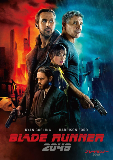

In [17]:
from imageio import imread
import PIL
import cv2
import numpy as np

thumbsize = 640
img = imread("https://www.sonypictures.jp/sites/default/files/styles/keyart_large/public/2018-06/2210060.jpg?itok=lvR6uRxP")
#img = imread("https://hips.hearstapps.com/jp.h-cdn.co/harpersbazaarjp/harpersbazaar-mig/images/celebrity/annehathaway-beauty-181116-hns/14/373570-3-jpn-JP/2018-35.jpg")
height, width = img.shape[:2]
if height > width:
    scale = thumbsize/height
else:
    scale = thumbsize/width
newsize = (int(width*scale), int(height*scale))
img = cv2.resize(img, newsize)
tiny = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4))
display(PIL.Image.fromarray(tiny))

In [26]:
# 写真に使われていた色を、RGB空間にプロットする。
import plotly.graph_objs as go

height, width = tiny.shape[:2]
Npix = height*width

pixels = tiny.reshape(Npix, 3)

colors = ['rgb({0},{1},{2})'.format(r,g,b) for r,g,b in pixels[:]]
trace=dict(type='scatter3d',
           x= pixels[:,0],
           y= pixels[:,1],
           z= pixels[:,2],
           mode='markers',
           marker=dict(color=colors,
                       size=3)
          )
fig = go.Figure(data=trace)
fig.update_layout(scene = dict(
                    xaxis_title='R',
                    yaxis_title='G',
                    zaxis_title='B'))
fig.show()

In [29]:
# Pythonデータサイエンスハンドブック 5.11.1
from sklearn.cluster import KMeans

def color_reduction(img, Ncolor):

    height, width = img.shape[:2]
    Npix = height*width

    #画像をピクセル列に変換する(そうしないとk-meansが使えない)
    pixels = img.reshape(Npix, 3)

    # 8つの代表的な色をさがさせる。
    kmeans = KMeans(n_clusters=Ncolor, max_iter=1000)
    kmeans.fit(pixels)

    # それぞれのピクセルに一番近い中心は何番か。
    new_pixels = kmeans.cluster_centers_[kmeans.predict(pixels)]

    # new_pixelsを8ビット整数にし、arrayの形をもとに戻す。
    reduced = new_pixels.astype(np.uint8).reshape(height, width, 3)
    return reduced, kmeans.cluster_centers_, kmeans

Ncolor=16
reduced, centers, kmeans = color_reduction(img, Ncolor)


In [30]:
# 各ピクセルの色が、どの色に減色されたかを散布図で示す。16の領域に分割されている。

import plotly.graph_objs as go

height, width = tiny.shape[:2]
Npix = height*width

pixels = tiny.reshape(Npix, 3)
pred   = kmeans.cluster_centers_[kmeans.predict(pixels)].reshape(Npix, 3)

colors = ['rgb({0},{1},{2})'.format(r,g,b) for r,g,b in pred[:]]
trace=dict(type='scatter3d',
           x= pixels[:,0],
           y= pixels[:,1],
           z= pixels[:,2],
           mode='markers',
           marker=dict(color=colors,
                       size=3)
          )
fig = go.Figure(data=trace)
fig.update_layout(scene = dict(
                    xaxis_title='R',
                    yaxis_title='G',
                    zaxis_title='B'))
fig.show()

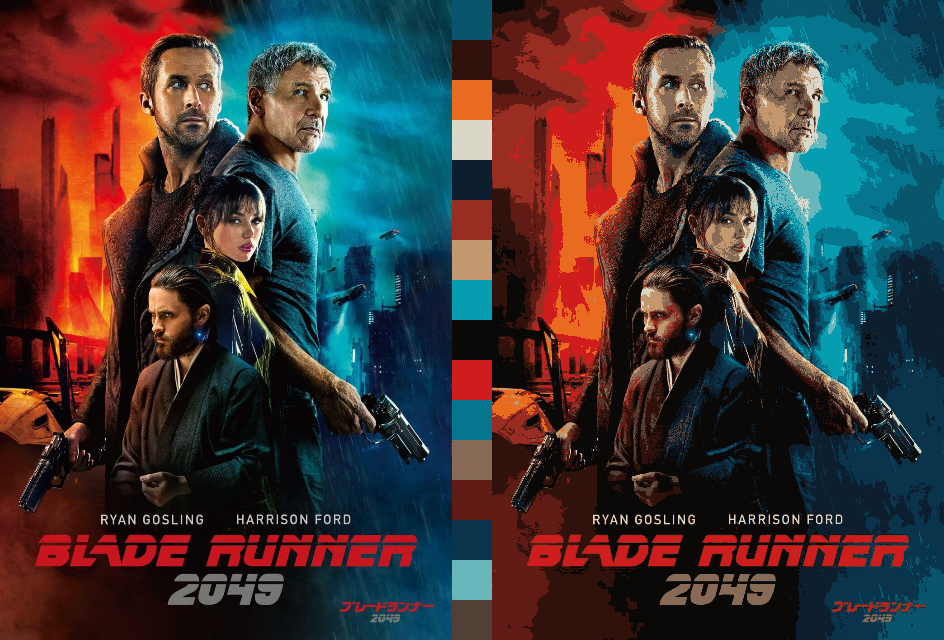

In [31]:
# 代表色を並べる
sqsize = newsize[1] // Ncolor
squares = np.zeros([newsize[1],sqsize,3])
for i in range(Ncolor):
    squares[i*sqsize:(i+1)*sqsize,:] = centers[i]
## display(PIL.Image.fromarray(squares.astype(np.uint8)))


# 貼りあわせて1枚にする。
newsize = [img.shape[0], img.shape[1]+sqsize+reduced.shape[1], 3]
panel = np.zeros(newsize, dtype=np.uint8)
panel[:, 0:img.shape[1]] = img
panel[:squares.shape[0], img.shape[1]:img.shape[1]+sqsize] = squares
panel[:, img.shape[1]+sqsize:] = reduced

display(PIL.Image.fromarray(panel))